<a href="https://colab.research.google.com/github/emmab-collab/PyTorch/blob/main/PyTorch_Basics_3_6_Deep_NN_with_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import numpy as np
import torchvision
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

np.random.seed(42)

# **1. Preparing the data**

In [ ]:
dataset=MNIST(root='data/',
              download=True,
             transform=ToTensor())

In [ ]:
img,label=dataset[0]
img.shape,label

(torch.Size([1, 28, 28]), 5)

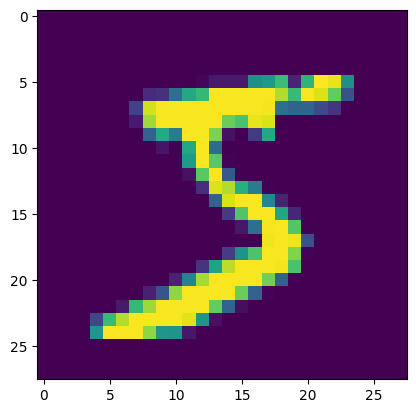

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(img[0])

In [ ]:
def split_indices(n,val_pct):
    n_val=int(val_pct*n)
    idxs=np.random.permutation(n)
    return idxs[n_val:],idxs[:n_val]

In [ ]:
train_indices,val_indices=split_indices(len(dataset),val_pct=0.2)
print(len(train_indices),len(val_indices))
print('Sample val indices :',val_indices[:20])

48000 12000
Sample val indices : [12628 37730 39991  8525  8279 51012 14871 15127  9366 33322 53390 21819
  5026 23428 45297 26354 30195 47038 20731 34047]


In [ ]:
batch_size=100

train_sampler=SubsetRandomSampler(train_indices)
train_dl=DataLoader(dataset,
                       batch_size,
                       sampler=train_sampler)

val_sampler=SubsetRandomSampler(val_indices)
val_dl=DataLoader(dataset,
                     batch_size,
                     sampler=val_sampler)

# **2. Model**

## **1. Création du modèle**

In [ ]:
import torch.nn as nn #neural_network_package
import torch.nn.functional as F #softmax, cross_entropy

In [ ]:
class MnistModel(nn.Module): #une classe de modèle
    def __init__(self,in_size,hidden_size,out_size):
        super().__init__() #superconstructeur de la classe mère
        self.linear1=nn.Linear(in_size,hidden_size)
        self.linear2=nn.Linear(hidden_size,out_size)

    def forward(self,xb):
        xb=xb.reshape(xb.size(0),-1) #xb est un batch of input
        out=self.linear1(xb)
        out=F.relu(out)
        out=self.linear2(out)
        return out

In [ ]:
input_size=784
num_classes=10
model=MnistModel(input_size,hidden_size=32,out_size=num_classes) #on crée un modèle de la classe MnistModel

In [ ]:
for t in model.parameters():
    print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [ ]:
for images,labels in train_dl:
    print('images.shape: ', images.shape)
    outputs=model(images)
    loss=F.cross_entropy(outputs,labels)
    print('Loss:',loss.item())
    break
print('outputs.shape: ',outputs.shape)
print('Sample outputs :\n',outputs[:2].data)

## **2. Using a GPU**

En PyTorch, ``device`` fait référence à **l’endroit où les tenseurs sont stockés** et où les opérations sont effectuées : soit sur le **CPU**, soit sur un **GPU** (s’il est disponible).

We can check if a GPU is available and the required NVIDA CUDA drivers are installed, using ``torch.cuda.is_available``

Then, we define a helper function ``get_default_device()`` to ensure that our code uses the GPU if available and defaults to using the CPU if it isn't.

Then we define a fonction that can move data and model to a chosen device : ``to_device(data,device)``

Finally we define a ``DeviceDataLoader`` class to wrap our existing data loaders and move data to the delected device.

In [ ]:
torch.cuda.is_available()

True

In [ ]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [ ]:
device=get_default_device()
device

device(type='cuda')

In [ ]:
def to_device(data,device):
    if isinstance(data,(list,tuple)): #si notre dataset est une liste ou tuple
        return [to_device(x,device)for x in data]
    return data.to(device,non_blocking=True)

In [ ]:
for images, labels in train_dl:
    print(images.shape)
    images=to_device(images,device)
    print(images.device)
    break

torch.Size([100, 1, 28, 28])
cuda:0


In [ ]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self,dl,device):
        self.dl=dl
        self.device=device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b,self.device) #ca genere le batch sans repetition

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
train_dl=DeviceDataLoader(train_dl,device)
val_dl=DeviceDataLoader(val_dl,device)

In [ ]:
for xb,yb in val_dl:
    print('xb device: ',xb.device)
    print('yb',yb)
    break

xb device:  cuda:0
yb tensor([9, 6, 9, 2, 4, 7, 8, 5, 1, 1, 8, 6, 5, 3, 7, 1, 1, 1, 4, 1, 3, 2, 5, 6,
        6, 4, 7, 5, 8, 1, 4, 9, 6, 0, 1, 4, 3, 7, 8, 0, 4, 1, 1, 6, 0, 2, 1, 9,
        8, 8, 1, 0, 8, 7, 8, 5, 1, 9, 4, 3, 7, 6, 2, 3, 1, 6, 6, 3, 4, 6, 2, 6,
        4, 9, 8, 5, 9, 7, 6, 2, 2, 5, 0, 2, 2, 7, 3, 8, 5, 7, 1, 1, 2, 3, 4, 9,
        0, 8, 4, 7], device='cuda:0')


# **3. Training the model**

## **1. Loss batch function**

In [ ]:
def loss_batch(model,loss_func,xb,yb,opt=None,metric=None):
    #Calculate loss
    preds=model(xb)
    loss=loss_func(preds,yb)

    if opt is not None:
        #Compute gradients
        loss.backward()
        #Update parameters
        opt.step()
        #Reset gradients
        opt.zero_grad()

    metric_result=None
    if metric is not None:
        #Compute the metric
        metric_result=metric(preds,yb)

    return loss.item(),len(xb),metric_result

## **2. Evaluate function**

In [ ]:
def evaluate(model,loss_fn,val_dl,metric=None):
    with torch.no_grad():
        results=[loss_batch(model,loss_fn,xb,yb,metric=metric)
                for xb,yb in val_dl]
        losses,nums,metrics=zip(*results)
        total=np.sum(nums)
        avg_loss=np.sum(np.multiply(losses,nums))/total
        avg_metric=None
        if metric is not None:
            avg_metric=np.sum(np.multiply(metrics,nums))/total

    return avg_loss,total,avg_metric

## **3. Fit function**

In [ ]:
def fit(epochs,lr,model,loss_fn,train_dl,val_dl,metric=None,opt_fn=None):
    losses,metrics=[],[]

    if opt_fn is None: opt_fn=torch.optim.SGD
    opt = opt_fn(model.parameters(), lr=lr)


    for epoch in range(epochs):
        #Train
        for xb,yb in train_dl:
            loss,_,_=loss_batch(model,loss_fn,xb,yb,opt)

        #Evaluate
        result=evaluate(model,loss_fn,val_dl,metric)
        val_loss,total,val_metric=result

        #Record Loss and metric
        losses.append(val_loss)
        metrics.append(val_metric)

        if metric is None:
            print(f'Epoch [{epoch+1}/{epochs}, Loss: {val_loss:.4f}')
        else:
            print(f'Epoch [{epoch+1}/{epochs}, Loss: {val_loss:.4f}, {metric.__name__} : {val_metric}')

    return losses,metrics

## **4. Accuracy function**

In [ ]:
def accuracy(outputs,labels):
    _,preds=torch.max(outputs,dim=1) #on prend juste l'index du max
    return torch.sum(preds==labels).item()/len(preds)

In [ ]:
model=MnistModel(input_size,hidden_size=32,out_size=num_classes)
to_device(model,device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [ ]:
val_loss,total,val_acc=evaluate(model,F.cross_entropy,val_dl,metric=accuracy)
print(f'Loss : {val_loss:.4f}, Accuracy : {val_acc:.4f}')

Loss : 2.3032, Accuracy : 0.1263


In [ ]:
losses1,metrics1=fit(5,0.5,model,F.cross_entropy,train_dl,val_dl,accuracy)

Epoch [1/5, Loss: 0.2166, accuracy : 0.9318333333333333
Epoch [2/5, Loss: 0.1641, accuracy : 0.9510833333333333
Epoch [3/5, Loss: 0.1373, accuracy : 0.9595
Epoch [4/5, Loss: 0.1305, accuracy : 0.9599166666666666
Epoch [5/5, Loss: 0.1399, accuracy : 0.96025


In [ ]:
losses2,metrics2=fit(5,0.1,model,F.cross_entropy,train_dl,val_dl,accuracy)

Epoch [1/5, Loss: 0.1111, accuracy : 0.96775
Epoch [2/5, Loss: 0.1086, accuracy : 0.9679166666666666
Epoch [3/5, Loss: 0.1103, accuracy : 0.9679166666666666
Epoch [4/5, Loss: 0.1087, accuracy : 0.9688333333333333
Epoch [5/5, Loss: 0.1088, accuracy : 0.9689166666666666


In [ ]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Accuracy vs No. of epochs')

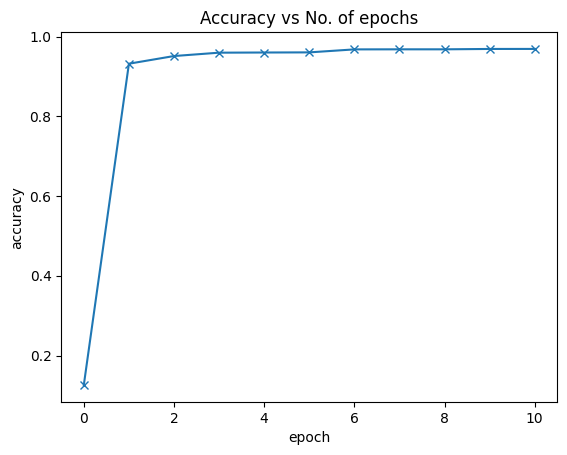

In [ ]:
accuracies=[val_acc]+metrics1+metrics2
plt.plot(accuracies,'-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs No. of epochs')